## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np 
import pandas as pd


def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    file_images = join(dirname,'images')
    filenames  = os.listdir(file_images)
    images=[]
    heights=[]
    widths=[]
    for name in filenames:
        fullname= join(file_images,name)
        img = imread(fullname)
        img = gray2rgb(img)
        H,W = img.shape[0], img.shape[1]
        img = resize(img,[100,100],mode='constant')
        images.append(img)
        heights.append(H)
        widths.append(W)
    file_csv= join(dirname,'gt.csv')
    df = pd.read_csv(file_csv)
    df.drop(df.columns[0],axis=1,inplace=True)
    for col in range(df.shape[1]):
        if col % 2 == 0:
            df.iloc[:,col] /= widths
        else:
            df.iloc[:,col] /= heights
    keypoints = df.values -0.5
        
                     
    return images, keypoints
    
    
    

imgs, keypoints = load_imgs_and_keypoints()

F:\Program_Files\Anaconda3\envs\machineLearningEnv\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

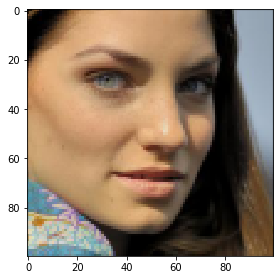

In [2]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
keypoints[0]


### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

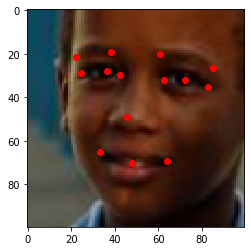

In [3]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.scatter((points[0::2] + 0.5)*100, (points[1::2] + 0.5)*100,color='r')
    
    
visualize_points(imgs[1], keypoints[1])

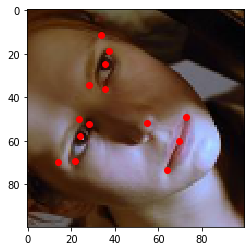

In [4]:
visualize_points(imgs[2], keypoints[2])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, keypoints, test_size=0.2)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

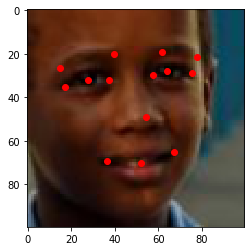

In [6]:

import copy
def flip_img(img, points):
    # Write your code for flipping here
    
    # flip horizontally
    #img_flip = cv2.flip(img, 1)
    img_flip = np.fliplr(img)
    points_flip = copy.deepcopy(points)

    for i in range(len(points) // 2):
        points_flip[2*i] = -points_flip[2*i]
    flip_indices = [(0,3),(1,2),(4,9),(5,8),(6,7),(11,13)]
    for a, b in flip_indices:
        points_flip[2*a],points_flip[2*b] = (points_flip[2*b],points_flip[2*a])
        points_flip[2*a+1],points_flip[2*b+1] = (points_flip[2*b+1],points_flip[2*a+1])

        
        
    return img_flip, points_flip

img_flip, points_flip = flip_img(imgs[1], keypoints[1])
visualize_points(img_flip, points_flip)

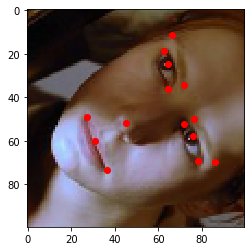

In [7]:
img_flip, points_flip = flip_img(imgs[2], keypoints[2])
visualize_points(img_flip, points_flip)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [8]:
# Write your code here
def augmentationData(imgs_train, points_train):
    aug_imgs = []
    aug_points = []
    for img, points in zip(imgs_train, points_train):
        img_flip, points_flip = flip_img(img, points)
        
        aug_imgs.append(img)
        aug_imgs.append(img_flip)
        aug_points.append(points)
        aug_points.append(points_flip)
        
    return np.asarray(aug_imgs), np.asarray(aug_points)


aug_imgs_train,aug_points_train = augmentationData(imgs_train, points_train)
aug_imgs_val,aug_points_val = augmentationData(imgs_val, points_val)

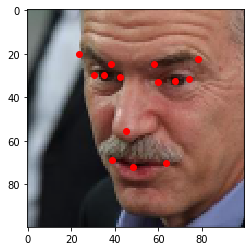

In [9]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

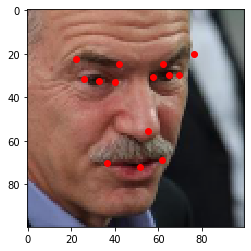

In [10]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

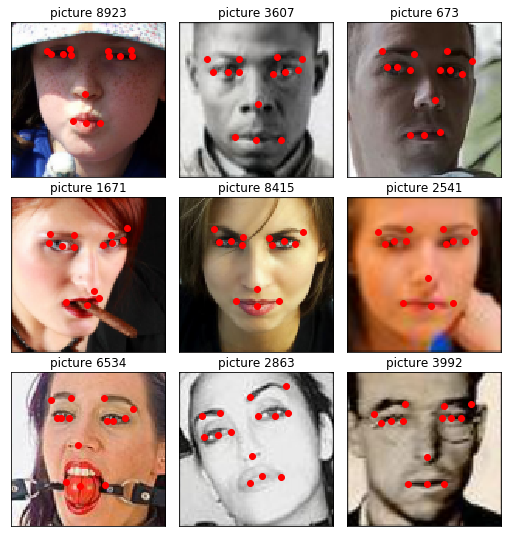

In [11]:
def plot_sample(img, points,ax):
    ax.imshow(img)
    ax.scatter((points[0::2] + 0.5)*100, (points[1::2] + 0.5)*100,color='r')
    
    
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(aug_imgs_train.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(aug_imgs_train[ipic], aug_points_train[ipic],ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [12]:
aug_imgs_train.shape

(9600, 100, 100, 3)

In [13]:
aug_points_train.shape

(9600, 28)

In [14]:
points_val=np.asarray(points_val)
imgs_val=np.asarray(imgs_val)
points_train=np.asarray(points_train)
imgs_train=np.asarray(imgs_train)


### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [18]:
import tensorflow as tf 

# Define here your model
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3), kernel_initializer='he_normal', input_shape= (100, 100, 3)) )
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    #model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), kernel_initializer='he_normal'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    #model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), kernel_initializer='he_normal'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    #model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, activation='tanh'))
    #model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(128, activation='tanh'))
    #model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(28))
    
    return model



Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [19]:

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 30:
        return 0.0002
    else:
        return 0.0001
        
        

In [20]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
# from keras.callbacks import ModelCheckpoint
# from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,period=5)

# Create a new model instance
model = create_model()
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


model.compile(loss=tf.keras.losses.MeanSquaredError(),optimizer=tf.keras.optimizers.Adam())

hist=model.fit(aug_imgs_train, aug_points_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(aug_imgs_val, aug_points_val),
          callbacks=[cp_callback,lr_callback])




Epoch 1/50
75/75 [==============================] - 25s 335ms/step - loss: 0.1202 - val_loss: 0.0029 - lr: 0.0010
Epoch 2/50
75/75 [==============================] - 25s 328ms/step - loss: 0.0031 - val_loss: 0.0029 - lr: 0.0010
Epoch 3/50
75/75 [==============================] - 25s 327ms/step - loss: 0.0031 - val_loss: 0.0028 - lr: 0.0010
Epoch 4/50
75/75 [==============================] - 25s 329ms/step - loss: 0.0031 - val_loss: 0.0028 - lr: 0.0010
Epoch 5/50
75/75 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00005: saving model to training/cp-0005.ckpt
75/75 [==============================] - 25s 334ms/step - loss: 0.0031 - val_loss: 0.0029 - lr: 0.0010
Epoch 6/50
75/75 [==============================] - 25s 330ms/step - loss: 0.0029 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/50
75/75 [==============================] - 25s 330ms/step - loss: 0.0027 - val_loss: 0.0026 - lr: 0.0010
Epoch 8/50
75/75 [==============================] - 25s 331ms/step - loss: 0.0027 - val

In [21]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
# Create a new model instance
model = create_model()
# Load the previously saved weights
model.load_weights(latest)


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [24]:
predicted_points = model.predict(imgs_val)
predicted_points[:2]

array([[-0.32192117, -0.2902078 , -0.10296834, -0.3013052 ,  0.11622059,
        -0.28739393,  0.3069979 , -0.27353874, -0.26230454, -0.18269403,
        -0.19025795, -0.20365305, -0.12030888, -0.20741022,  0.10398729,
        -0.20693025,  0.18803029, -0.21035106,  0.26267475, -0.21039204,
         0.01517425,  0.01405093, -0.11579145,  0.18158391,  0.01122007,
         0.19764318,  0.15562661,  0.19408561],
       [-0.30814683, -0.15181111, -0.13517168, -0.23523772,  0.08040207,
        -0.29982468,  0.18325497, -0.31945077, -0.23816444, -0.06402614,
        -0.18897805, -0.13947308, -0.1138633 , -0.13852283,  0.05732869,
        -0.20806077,  0.11562949, -0.25098202,  0.16754311, -0.25692838,
         0.04123707, -0.05018368, -0.06797099,  0.16925511,  0.10318405,
         0.12452476,  0.2103063 ,  0.1068017 ]], dtype=float32)

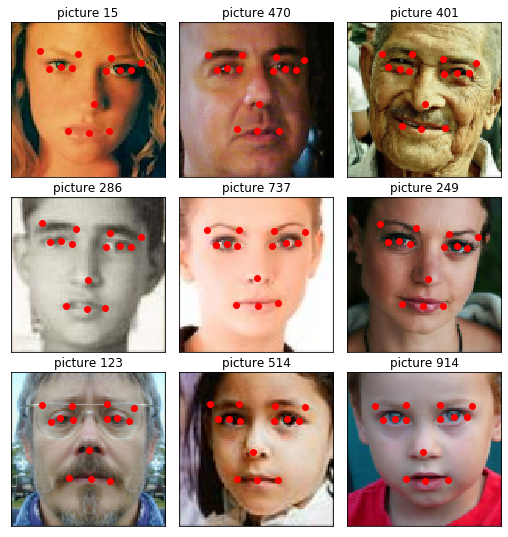

In [27]:
# Example of output


fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(imgs_val.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(imgs_val[ipic], predicted_points[ipic],ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()